<a href="https://colab.research.google.com/github/bscs16033/bscs16033_COVID19_DLSpring2020/blob/master/Deep_Learning_Assignmnet_5_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd '/content/drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Assignment 5-Part 2'

/content/drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Assignment 5-Part 2


In [0]:
ls

 A_05_Part_02_Dataset/                    vgg16_focal_loss_alpha3.pth
'Copy of A_05_Part_02_Dataset.zip'        vgg16_focal_loss.pth
 Deep_Learning_Assignmnet_5_Part2.ipynb   vgg16_lr_001_fc2_ft.pth
 resnet18_focal_loss.pth                  vgg16_lr_001_ft.pth
 resnet18_lr_001_ft.pth


In [0]:
!unzip 'Copy of A_05_Part_02_Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: A_05_Part_02_Dataset/Train/normal/52c173d2-14e2-4b91-9770-e2f7900399de.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52d1f158-6cde-4676-94bf-bc5f8bab0cc6.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52d3b6f1-76d3-487b-88ff-663f80ac4da9.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52e21c71-71d1-40cb-9b5c-389fd41db723.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52edd24a-15db-449d-b0c5-8051eab5fd1e.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52f18c9e-7262-4fcc-a6bc-78e707214886.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52f53bb5-81fb-408b-adc7-2f8ae8932b31.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52fee036-272a-455a-9714-b6ff73e28403.png  
  inflating: A_05_Part_02_Dataset/Train/normal/535c2337-e755-43ea-ab1d-6547a584776d.png  
  inflating: A_05_Part_02_Dataset/Train/normal/536ba3bf-b867-4035-b483-35e9cbda9c0f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
data_dir = '/content/drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Assignment 5-Part 2/A_05_Part_02_Dataset'

In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.RandomCrop(224),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, num_workers=4, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, num_workers=4, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, num_workers=4, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [0]:
print("Train Data...")
print(len(train_data))
print("Validation Data...")
print(len(valid_data))
print("Test Data...")
print(len(test_data))

Train Data...
6200
Validation Data...
628
Test Data...
629


# **Task1: VGG-16** 

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
for name, param in vgg16.named_parameters():
    print(name, param.requires_grad)

features.0.weight True
features.0.bias True
features.2.weight True
features.2.bias True
features.5.weight True
features.5.bias True
features.7.weight True
features.7.bias True
features.10.weight True
features.10.bias True
features.12.weight True
features.12.bias True
features.14.weight True
features.14.bias True
features.17.weight True
features.17.bias True
features.19.weight True
features.19.bias True
features.21.weight True
features.21.bias True
features.24.weight True
features.24.bias True
features.26.weight True
features.26.bias True
features.28.weight True
features.28.bias True
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


In [0]:
# Freeze training for all CNN Layers
# for param in vgg16.features.parameters():
#     param.requires_grad = False

In [0]:
for name, param in vgg16.named_parameters():
    print(name, param.requires_grad)

features.0.weight True
features.0.bias True
features.2.weight True
features.2.bias True
features.5.weight True
features.5.bias True
features.7.weight True
features.7.bias True
features.10.weight True
features.10.bias True
features.12.weight True
features.12.bias True
features.14.weight True
features.14.bias True
features.17.weight True
features.17.bias True
features.19.weight True
features.19.bias True
features.21.weight True
features.21.bias True
features.24.weight True
features.24.bias True
features.26.weight True
features.26.bias True
features.28.weight True
features.28.bias True
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


In [0]:
FC = list(vgg16.classifier)[:-7]
print(FC)

[]


In [0]:
# FC.extend([nn.Linear(in_features=25088, out_features=4096, bias=True)])
# FC.extend([nn.ReLU(inplace=False)])
# FC.extend([nn.Dropout(p=0.5, inplace=True)])
# FC.extend([nn.Linear(in_features=4096, out_features=128, bias=True)])
# FC.extend([nn.ReLU(inplace=False)])
# FC.extend([nn.Dropout(p=0.5, inplace=True)])
# FC.extend([nn.Linear(in_features=128, out_features=3, bias=True)])

FC.extend([nn.Linear(in_features=25088, out_features=1024, bias=True)])
FC.extend([nn.ReLU(inplace=False)])
FC.extend([nn.Dropout(p=0.5, inplace=True)])
FC.extend([nn.Linear(in_features=1024, out_features=3, bias=True)])

print(FC)

[Linear(in_features=25088, out_features=1024, bias=True), ReLU(), Dropout(p=0.5, inplace=True), Linear(in_features=1024, out_features=3, bias=True)]


In [0]:
# vgg16.classifier[0].out_features = 430
# vgg16.classifier[3].in_features = 430
# vgg16.classifier[3].out_features = len(class_names)

# Remove the Last Layer
# features = list(vgg16.classifier)[0:4] # Remove last layer
vgg16.classifier = nn.Sequential(*FC)

In [0]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# # Load Model
# vgg16 = models.vgg16(pretrained=False)
# vgg16.classifier[0].out_features = 430
# vgg16.classifier[3].in_features = 430
# vgg16.classifier[3].out_features = len(class_names)

# # Remove the Last Layer
# features = list(vgg16.classifier)[0:4] # Remove last layer
# vgg16.classifier = nn.Sequential(*features)
# vgg16.load_state_dict(torch.load('vgg16_lr_0001_ft.pth'))
# # torch.save(vgg16.state_dict(), )
# print(vgg16)


In [0]:
# for name, param in vgg16.named_parameters():
#     print(name, param.requires_grad)

In [0]:
# print(train_data)

In [0]:
# def FocalLoss(Y_pred, Y):
#   # Takes input as one-hot vectors
#   focalLoss = 0.0
#   alpha = 0.5
#   gamma = 1.5
#   print(Y_pred.shape)
#   print(Y.shape)
#   # If a batch has 64 items, it'll run 64 times
#   for i in range(Y_pred.shape[0]):
#     # If we have 3 classes, it'll run 3 times
#     # for j in range(Y_pred.shape[1]):
#     p_t = Y[i] * Y_pred[i]
#     focalLoss -= (alpha*((1-p_t)**gamma))* 


In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)


Training Accuracy of Epoch 0: 76 %
Training Loss of Epoch 0: 34.448701083660126
Validation Accuracy of Epoch 0: 83 %
Validation Loss of Epoch 0: tensor(1.9063, device='cuda:0')



Training Accuracy of Epoch 1: 86 %
Training Loss of Epoch 1: 16.317803166806698
Validation Accuracy of Epoch 1: 83 %
Validation Loss of Epoch 1: tensor(1.9846, device='cuda:0')



Training Accuracy of Epoch 2: 88 %
Training Loss of Epoch 2: 12.711687657982111
Validation Accuracy of Epoch 2: 87 %
Validation Loss of Epoch 2: tensor(1.2347, device='cuda:0')



Training Accuracy of Epoch 3: 88 %
Training Loss of Epoch 3: 12.887085103429854
Validation Accuracy of Epoch 3: 87 %
Validation Loss of Epoch 3: tensor(1.5021, device='cuda:0')



Training Accuracy of Epoch 4: 89 %
Training Loss of Epoch 4: 11.318055583164096
Validation Accuracy of Epoch 4: 89 %
Validation Loss of Epoch 4: tensor(1.2610, device='cuda:0')



Training Accuracy of Epoch 5: 89 %
Training Loss of Epoch 5: 11.250039919279516
Validation Accuracy of Epoch 5: 87 %
Validation Loss of Epoch 5: tensor(1.3026, device='cuda:0')



Training Accuracy of Epoch 6: 90 %
Training Loss of Epoch 6: 9.442862767726183
Validation Accuracy of Epoch 6: 89 %
Validation Loss of Epoch 6: tensor(1.0778, device='cuda:0')



Training Accuracy of Epoch 7: 91 %
Training Loss of Epoch 7: 7.987593065947294
Validation Accuracy of Epoch 7: 92 %
Validation Loss of Epoch 7: tensor(0.7809, device='cuda:0')



Training Accuracy of Epoch 8: 91 %
Training Loss of Epoch 8: 8.056622923351824
Validation Accuracy of Epoch 8: 91 %
Validation Loss of Epoch 8: tensor(1.1595, device='cuda:0')



Training Accuracy of Epoch 9: 91 %
Training Loss of Epoch 9: 7.79777984181419


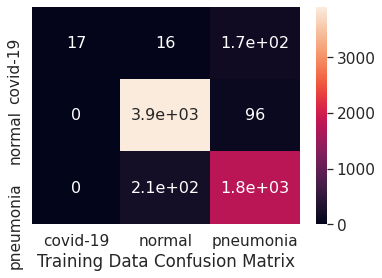

Validation Accuracy of Epoch 9: 91 %
Validation Loss of Epoch 9: tensor(0.7249, device='cuda:0')


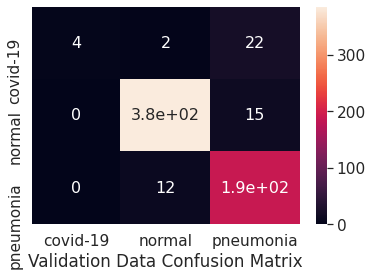

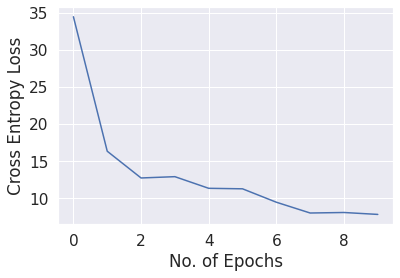

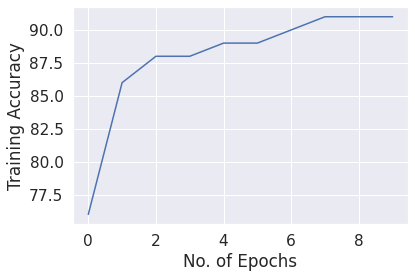

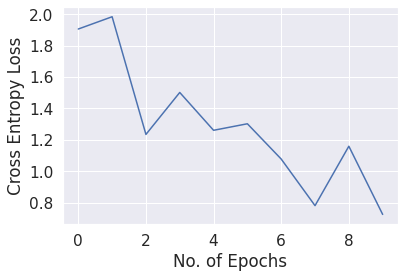

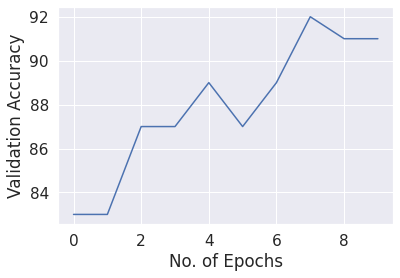

Finished Training


In [0]:
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

# alpha = torch.Tensor([0.6, 0.2, 0.2])
# alphs = [0.6, 0.2, 0.2]
gamma = 0.8
# alpha = alpha.to(device)
alpha = 4

vgg16.train()
lossEpochs = []
accEpochs = []
lossValid = []
accValid = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0

    confusionMatrix = np.zeros((3, 3))
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data

        # Convert Labels to one-hot
        labels_onehot = []
        for i in range(labels.shape[0]):
          if labels[i] == 0:
            labels_onehot.append([1, 0, 1])
          elif labels[i] == 1:
            labels_onehot.append([0, 1, 0])
          else:
            labels_onehot.append([0, 0, 1])
        labels = torch.Tensor(labels_onehot)

        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        # print('outputs[0]')
        # print(outputs.shape)
        # print(labels.shape)

        # Focal Loss
        crossEntropyLoss = criterion(outputs, labels)   #----> compute loss
        # print(crossEntropyLoss)
        p_t = torch.exp(-crossEntropyLoss)
        # loss = (alpha * ((1-p_t)**gamma) * crossEntropyLoss).mean()
        loss = (alpha * ((1-p_t)**gamma) * crossEntropyLoss)

        # ce_loss = torch.nn.functional.cross_entropy(outputs, targets, reduction='none') # important to add reduction='none' to keep per-batch-item loss
        # pt = torch.exp(-ce_loss)
        # focal_loss = (alpha * (1-pt)**gamma * ce_loss).mean() # mean over the batch
        # print(loss)
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()

        # print('outputs')
        # print(outputs)

        # print(predicted.shape)
        # print(outputs)
        # break
        threshold = Variable(torch.Tensor([0.5]))  # threshold
        threshold = threshold.to(device)
        total += labels.shape[0]
        for i in range(labels.shape[0]):
          outputs_threshold = (outputs[i] > threshold).float() * 1
          correct += torch.all(torch.eq(outputs_threshold, labels[i]))
        
        if epoch == (Epochs-1):
          _, labels_original = data
          outputs_numpy = outputs.cpu().detach().numpy()
          covid_label = np.array([1, 0, 1])
          normal_label = np.array([0, 1, 0])
          pneumonia_label = np.array([0, 0, 1])
          outputs_original = []
          for i in range(outputs.shape[0]):
            if (outputs_numpy[i] == covid_label).all():
              outputs_original.append(0)
            elif (outputs_numpy[i] == normal_label).all():
              outputs_original.append(1)
            elif (outputs_numpy[i] == pneumonia_label).all():
              outputs_original.append(2)
            else:
              outputs_original.append(outputs_numpy[i].argmax(axis=0))
      
          # print(labels_original.shape)
          # print(np.array(outputs_original).shape)
          # print(labels_original)
          # print(outputs_original)
          confusionMatrix += confusion_matrix(labels_original, np.array(outputs_original), labels=[0, 1, 2])

        # correct += (predicted == labels).sum().item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
    
    acc = 100 * correct / total
    print('Training Accuracy of Epoch ' + str(epoch) + ': %d %%' % (acc))
    print('Training Loss of Epoch ' + str(epoch) + ': ' + str(running_loss))
    lossEpochs.append(running_loss)
    accEpochs.append(acc)

    if epoch == (Epochs-1):
      df_cm = pd.DataFrame(confusionMatrix, class_names, class_names)
      sn.set(font_scale=1.4) # for label size
      sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
      plt.xlabel("Training Data Confusion Matrix")
      plt.show()
    

    # Validation Accuracy and Loss
    correct = 0
    total = 0
    valid_loss = 0.0
    valid_loss_total = 0.0
    confusionMatrix = np.zeros((3, 3));
    with torch.no_grad():
        for valid_data in validloader:
            images, labels = valid_data

            # Convert Labels to one-hot
            labels_onehot = []
            for i in range(labels.shape[0]):
              if labels[i] == 0:
                labels_onehot.append([1, 0, 1])
              elif labels[i] == 1:
                labels_onehot.append([0, 1, 0])
              else:
                labels_onehot.append([0, 0, 1])
            labels = torch.Tensor(labels_onehot)

            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            # valid_loss = criterion(outputs, labels)
            
            # Focal Loss
            crossEntropyLoss = criterion(outputs, labels)   #----> compute loss
            p_t = torch.exp(-crossEntropyLoss)
            # valid_loss = (alpha * ((1-p_t)**gamma) * crossEntropyLoss).mean()
            valid_loss = (alpha * ((1-p_t)**gamma) * crossEntropyLoss)

            valid_loss_total += valid_loss

            
            # _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()

            threshold = Variable(torch.Tensor([0.5]))  # threshold
            threshold = threshold.to(device)
            total += labels.shape[0]
            
            for i in range(labels.shape[0]):
              outputs_threshold = (outputs[i] > threshold).float() * 1
              correct += torch.all(torch.eq(outputs_threshold, labels[i]))
            
            if epoch == (Epochs-1):
              _, labels_original = valid_data
              outputs_numpy = outputs.cpu().detach().numpy()
              covid_label = np.array([1, 0, 1])
              normal_label = np.array([0, 1, 0])
              pneumonia_label = np.array([0, 0, 1])
              outputs_original = []
              for i in range(outputs.shape[0]):
                if (outputs_numpy[i] == covid_label).all():
                  outputs_original.append(0)
                elif (outputs_numpy[i] == normal_label).all():
                  outputs_original.append(1)
                elif (outputs_numpy[i] == pneumonia_label).all():
                  outputs_original.append(2)
                else:
                  outputs_original.append(outputs_numpy[i].argmax(axis=0))
          
              confusionMatrix += confusion_matrix(labels_original, np.array(outputs_original), labels=[0, 1, 2])
      

    acc = 100 * correct / total
    print('Validation Accuracy of Epoch ' + str(epoch) + ': %d %%' % (acc))
    print('Validation Loss of Epoch ' + str(epoch) + ': ' + str(valid_loss_total))
    lossValid.append(valid_loss_total)
    accValid.append(acc)

    if epoch == (Epochs-1):
      df_cm = pd.DataFrame(confusionMatrix, class_names, class_names)
      sn.set(font_scale=1.4) # for label size
      sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
      plt.xlabel("Validation Data Confusion Matrix")
      plt.show()
    
    torch.save(vgg16.state_dict(), 'vgg16_focal_loss_gamma_1_5.pth')


plt.plot(lossEpochs)
plt.xlabel("No. of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.show()

plt.plot(accEpochs)
plt.xlabel("No. of Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(lossValid)
plt.xlabel("No. of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.show()

plt.plot(accValid)
plt.xlabel("No. of Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

print('Finished Training')

In [0]:
print(test_data[0])
print(test_data)

(tensor([[[-0.3712, -0.3712, -0.3541,  ..., -0.0801, -0.0458, -0.0458],
         [-0.2684, -0.3198, -0.3198,  ..., -0.0458, -0.1143, -0.1314],
         [-0.4226, -0.3369, -0.3027,  ..., -0.1999, -0.3027, -0.3198],
         ...,
         [-0.1486, -0.0972, -0.0629,  ..., -1.9980, -1.9809, -1.9809],
         [-0.1657, -0.0972, -0.0801,  ..., -1.9980, -1.9809, -1.9809],
         [-0.1657, -0.1143, -0.0972,  ..., -1.9980, -1.9809, -1.9809]],

        [[-0.2500, -0.2500, -0.2325,  ...,  0.0476,  0.0826,  0.0826],
         [-0.1450, -0.1975, -0.1975,  ...,  0.0826,  0.0126, -0.0049],
         [-0.3025, -0.2150, -0.1800,  ..., -0.0749, -0.1800, -0.1975],
         ...,
         [-0.0224,  0.0301,  0.0651,  ..., -1.9132, -1.8957, -1.8957],
         [-0.0399,  0.0301,  0.0476,  ..., -1.9132, -1.8957, -1.8957],
         [-0.0399,  0.0126,  0.0301,  ..., -1.9132, -1.8957, -1.8957]],

        [[-0.0267, -0.0267, -0.0092,  ...,  0.2696,  0.3045,  0.3045],
         [ 0.0779,  0.0256,  0.0256,  ...,  

In [0]:
# test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)
print(len(test_data.imgs))
print(test_data.imgs[200][0])

629
/content/drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Assignment 5-Part 2/A_05_Part_02_Dataset/Test/temp_name/279.png


In [0]:
print(test_data.imgs)

[('/content/drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Assignment 5-Part 2/A_05_Part_02_Dataset/Test/temp_name/0.png', 0), ('/content/drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Assignment 5-Part 2/A_05_Part_02_Dataset/Test/temp_name/1.png', 0), ('/content/drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Assignment 5-Part 2/A_05_Part_02_Dataset/Test/temp_name/10.png', 0), ('/content/drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Assignment 5-Part 2/A_05_Part_02_Dataset/Test/temp_name/100.png', 0), ('/content/drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Assignment 5-Part 2/A_05_Part_02_Dataset/Test/temp_name/101.png', 0), ('/content/drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Assignment 5-Part 2/A_05_Part_02_Dataset/Test/temp_name/102.png', 0), ('/content/drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Assignment 5-Part 2/A_05_Part_02_Dataset/Test/temp_name/103.png', 0), ('/content/drive/My Driv

In [0]:
num_images = len(test_data.imgs)
output_predictions = np.zeros((num_images, 3))

In [0]:
temp_counter = 0
# Validation Accuracy and Loss
with torch.no_grad():
    for t_data in testloader:
        images, labels = t_data

        # Convert Labels to one-hot
        labels_onehot = []
        for i in range(labels.shape[0]):
          if labels[i] == 0:
            labels_onehot.append([1, 0, 1])
          elif labels[i] == 1:
            labels_onehot.append([0, 1, 0])
          else:
            labels_onehot.append([0, 0, 1])
        labels = torch.Tensor(labels_onehot)

        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)

        # threshold = Variable(torch.Tensor([0.5]))  # threshold
        # threshold = threshold.to(device)
        
        # for i in range(labels.shape[0]):
        #   outputs_threshold = (outputs[i] > threshold).float() * 1

        outputs_numpy = outputs.cpu().detach().numpy()
        outputs_numpy = (outputs_numpy>=0.5) * 1
        
        #swapping 2nd and 3rd columns
        # right now the predictions come as 'covid-19 at index=0', 'normal at index=1' pneumonia at 'index=2'
        # What i want is 'covid-19 at index=0', 'pneumonia at index=1' normal at 'index=2'
        outputs_numpy = outputs_numpy[:, [0, 2, 1]]
        # print(len(images))
        output_predictions[temp_counter:temp_counter+len(images)][:] = outputs_numpy
        temp_counter += len(images)
        # break

64
64
64
64
64
64
64
64
64
53


In [0]:
print(output_predictions)

[[1. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [0]:
csv_data = []

In [0]:
for i in range(len(test_data.imgs)):
  img_name = test_data.imgs[i][0]
  csv_data.append([img_name.rsplit('/', 1)[1], output_predictions[i][0], output_predictions[i][1], output_predictions[i][2]])

In [0]:
csv_data = np.array(csv_data)
print(csv_data)

[['0.png' '1.0' '1.0' '0.0']
 ['1.png' '0.0' '0.0' '1.0']
 ['10.png' '0.0' '0.0' '1.0']
 ...
 ['97.png' '0.0' '0.0' '1.0']
 ['98.png' '0.0' '0.0' '1.0']
 ['99.png' '0.0' '0.0' '1.0']]


In [0]:
np.savetxt("test_predictions.csv", csv_data, delimiter=",", fmt='%s')

# **Task1: ResNet-18** 

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
print(resnet18.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [0]:
FC = []
print(FC)

[]


In [0]:
FC.extend([nn.Linear(in_features=512, out_features=430, bias=True)])
FC.extend([nn.ReLU(inplace=False)])
FC.extend([nn.Dropout(p=0.5, inplace=True)])
FC.extend([nn.Linear(in_features=430, out_features=3, bias=True)])
# FC.extend([nn.ReLU(inplace=False)])
# FC.extend([nn.Dropout(p=0.5, inplace=True)])
# FC.extend([nn.Linear(in_features=128, out_features=3, bias=True)])
print(FC)

[Linear(in_features=512, out_features=430, bias=True), ReLU(), Dropout(p=0.5, inplace=True), Linear(in_features=430, out_features=3, bias=True)]


In [0]:
resnet18.fc = nn.Sequential(*FC)

In [0]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# resnet18.fc = nn.Sequential(
#   nn.Linear(output_of_cnn_layers, 430, bias=True),
#   nn.ReLU(inplace=True),
#   nn.Dropout(p=0.5, inplace=False),
#   nn.Linear(430, len(class_names), bias=True)
# )

In [0]:
# print(resnet18)

In [0]:
for name, param in resnet18.named_parameters():
    print(name, param.requires_grad)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.downsample.0.weight True
layer2.0.downsample.1.weight True
layer2.0.downsample.1.bias True
layer2.1.conv1.weight True
layer2.1.bn1.weight True
layer2.1.bn1.bias True
layer2.1.conv2.weight True
layer2.1.bn2.weight True
layer2.1.bn2.bias True
layer3.0.conv1.weight True
layer3.0.bn1.weight True
layer3.0.bn1.bias True
layer3.0.conv2.weight True
layer3.0.bn2.weight True
layer3.0.bn2.bias True
layer3.0.downsample.0.weight True
layer3.0.downsample.1.weight True
layer3.0.downsample.1.bias True
la

In [0]:
# Freeze training for all layers
# for param in resnet18.parameters():
#     param.requires_grad = False 

# for param in resnet18.fc.parameters():
#     param.requires_grad = True

In [0]:
for name, param in resnet18.named_parameters():
    print(name, param.requires_grad)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.downsample.0.weight True
layer2.0.downsample.1.weight True
layer2.0.downsample.1.bias True
layer2.1.conv1.weight True
layer2.1.bn1.weight True
layer2.1.bn1.bias True
layer2.1.conv2.weight True
layer2.1.bn2.weight True
layer2.1.bn2.bias True
layer3.0.conv1.weight True
layer3.0.bn1.weight True
layer3.0.bn1.bias True
layer3.0.conv2.weight True
layer3.0.bn2.weight True
layer3.0.bn2.bias True
layer3.0.downsample.0.weight True
layer3.0.downsample.1.weight True
layer3.0.downsample.1.bias True
la

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



Training Accuracy of Epoch 0: 54 %
Training Loss of Epoch 0: 31.893045350909233


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Validation Accuracy of Epoch 0: 73 %
Validation Loss of Epoch 0: tensor(1.7183, device='cuda:0')



Training Accuracy of Epoch 1: 79 %
Training Loss of Epoch 1: 10.843412049114704
Validation Accuracy of Epoch 1: 82 %
Validation Loss of Epoch 1: tensor(0.9536, device='cuda:0')



Training Accuracy of Epoch 2: 83 %
Training Loss of Epoch 2: 7.104920556768775
Validation Accuracy of Epoch 2: 84 %
Validation Loss of Epoch 2: tensor(0.6832, device='cuda:0')



Training Accuracy of Epoch 3: 84 %
Training Loss of Epoch 3: 6.344827394466847
Validation Accuracy of Epoch 3: 84 %
Validation Loss of Epoch 3: tensor(0.6654, device='cuda:0')



Training Accuracy of Epoch 4: 85 %
Training Loss of Epoch 4: 5.404349904507399
Validation Accuracy of Epoch 4: 87 %
Validation Loss of Epoch 4: tensor(0.5231, device='cuda:0')



Training Accuracy of Epoch 5: 85 %
Training Loss of Epoch 5: 4.781152852810919
Validation Accuracy of Epoch 5: 87 %
Validation Loss of Epoch 5: tensor(0.5542, device='cuda:0')



Training Accuracy of Epoch 6: 86 %
Training Loss of Epoch 6: 4.442821115255356
Validation Accuracy of Epoch 6: 87 %
Validation Loss of Epoch 6: tensor(0.4591, device='cuda:0')



Training Accuracy of Epoch 7: 87 %
Training Loss of Epoch 7: 3.951134760864079
Validation Accuracy of Epoch 7: 87 %
Validation Loss of Epoch 7: tensor(0.4474, device='cuda:0')



Training Accuracy of Epoch 8: 87 %
Training Loss of Epoch 8: 4.028383455704898
Validation Accuracy of Epoch 8: 87 %
Validation Loss of Epoch 8: tensor(0.4028, device='cuda:0')



Training Accuracy of Epoch 9: 87 %
Training Loss of Epoch 9: 3.711693376302719


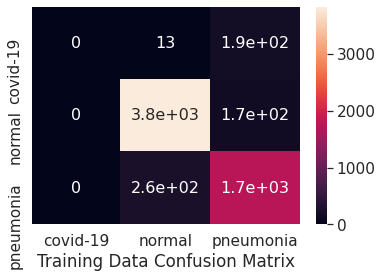

Validation Accuracy of Epoch 9: 87 %
Validation Loss of Epoch 9: tensor(0.4100, device='cuda:0')


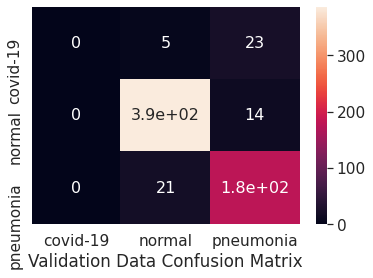

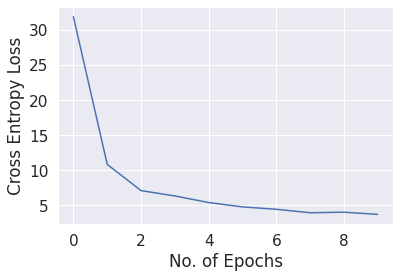

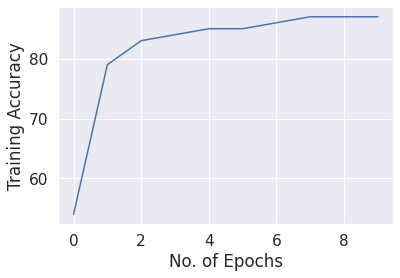

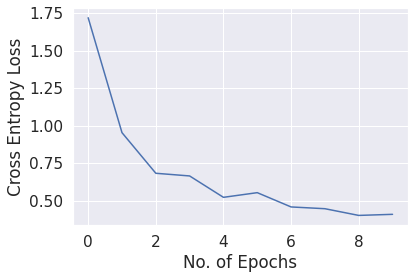

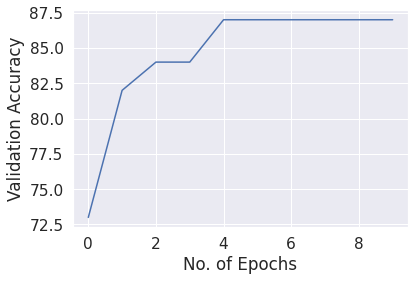

Finished Training


In [0]:
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

# alpha = torch.Tensor([0.6, 0.2, 0.2])
# alphs = [0.6, 0.2, 0.2]
gamma = 1.5
# alpha = alpha.to(device)
alpha = 4

resnet18.train()
lossEpochs = []
accEpochs = []
lossValid = []
accValid = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0

    confusionMatrix = np.zeros((3, 3))
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data

        # Convert Labels to one-hot
        labels_onehot = []
        for i in range(labels.shape[0]):
          if labels[i] == 0:
            labels_onehot.append([1, 0, 1])
          elif labels[i] == 1:
            labels_onehot.append([0, 1, 0])
          else:
            labels_onehot.append([0, 0, 1])
        labels = torch.Tensor(labels_onehot)

        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        # print('outputs[0]')
        # print(outputs.shape)
        # print(labels.shape)

        # Focal Loss
        crossEntropyLoss = criterion(outputs, labels)   #----> compute loss
        # print(crossEntropyLoss)
        p_t = torch.exp(-crossEntropyLoss)
        # loss = (alpha * ((1-p_t)**gamma) * crossEntropyLoss).mean()
        loss = (alpha * ((1-p_t)**gamma) * crossEntropyLoss)

        # ce_loss = torch.nn.functional.cross_entropy(outputs, targets, reduction='none') # important to add reduction='none' to keep per-batch-item loss
        # pt = torch.exp(-ce_loss)
        # focal_loss = (alpha * (1-pt)**gamma * ce_loss).mean() # mean over the batch
        # print(loss)
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()

        # print('outputs')
        # print(outputs)

        # print(predicted.shape)
        # print(outputs)
        # break
        threshold = Variable(torch.Tensor([0.5]))  # threshold
        threshold = threshold.to(device)
        total += labels.shape[0]
        for i in range(labels.shape[0]):
          outputs_threshold = (outputs[i] > threshold).float() * 1
          correct += torch.all(torch.eq(outputs_threshold, labels[i]))
        
        if epoch == (Epochs-1):
          _, labels_original = data
          outputs_numpy = outputs.cpu().detach().numpy()
          covid_label = np.array([1, 0, 1])
          normal_label = np.array([0, 1, 0])
          pneumonia_label = np.array([0, 0, 1])
          outputs_original = []
          for i in range(outputs.shape[0]):
            if (outputs_numpy[i] == covid_label).all():
              outputs_original.append(0)
            elif (outputs_numpy[i] == normal_label).all():
              outputs_original.append(1)
            elif (outputs_numpy[i] == pneumonia_label).all():
              outputs_original.append(2)
            else:
              outputs_original.append(outputs_numpy[i].argmax(axis=0))
      
          # print(labels_original.shape)
          # print(np.array(outputs_original).shape)
          # print(labels_original)
          # print(outputs_original)
          confusionMatrix += confusion_matrix(labels_original, np.array(outputs_original), labels=[0, 1, 2])

        # correct += (predicted == labels).sum().item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
    
    acc = 100 * correct / total
    print('Training Accuracy of Epoch ' + str(epoch) + ': %d %%' % (acc))
    print('Training Loss of Epoch ' + str(epoch) + ': ' + str(running_loss))
    lossEpochs.append(running_loss)
    accEpochs.append(acc)

    if epoch == (Epochs-1):
      df_cm = pd.DataFrame(confusionMatrix, class_names, class_names)
      sn.set(font_scale=1.4) # for label size
      sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
      plt.xlabel("Training Data Confusion Matrix")
      plt.show()
    

    # Validation Accuracy and Loss
    correct = 0
    total = 0
    valid_loss = 0.0
    valid_loss_total = 0.0
    confusionMatrix = np.zeros((3, 3));
    with torch.no_grad():
        for valid_data in validloader:
            images, labels = valid_data

            # Convert Labels to one-hot
            labels_onehot = []
            for i in range(labels.shape[0]):
              if labels[i] == 0:
                labels_onehot.append([1, 0, 1])
              elif labels[i] == 1:
                labels_onehot.append([0, 1, 0])
              else:
                labels_onehot.append([0, 0, 1])
            labels = torch.Tensor(labels_onehot)

            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            # valid_loss = criterion(outputs, labels)
            
            # Focal Loss
            crossEntropyLoss = criterion(outputs, labels)   #----> compute loss
            p_t = torch.exp(-crossEntropyLoss)
            # valid_loss = (alpha * ((1-p_t)**gamma) * crossEntropyLoss).mean()
            valid_loss = (alpha * ((1-p_t)**gamma) * crossEntropyLoss)

            valid_loss_total += valid_loss

            
            # _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()

            threshold = Variable(torch.Tensor([0.5]))  # threshold
            threshold = threshold.to(device)
            total += labels.shape[0]
            
            for i in range(labels.shape[0]):
              outputs_threshold = (outputs[i] > threshold).float() * 1
              correct += torch.all(torch.eq(outputs_threshold, labels[i]))
            
            if epoch == (Epochs-1):
              _, labels_original = valid_data
              outputs_numpy = outputs.cpu().detach().numpy()
              covid_label = np.array([1, 0, 1])
              normal_label = np.array([0, 1, 0])
              pneumonia_label = np.array([0, 0, 1])
              outputs_original = []
              for i in range(outputs.shape[0]):
                if (outputs_numpy[i] == covid_label).all():
                  outputs_original.append(0)
                elif (outputs_numpy[i] == normal_label).all():
                  outputs_original.append(1)
                elif (outputs_numpy[i] == pneumonia_label).all():
                  outputs_original.append(2)
                else:
                  outputs_original.append(outputs_numpy[i].argmax(axis=0))
          
              confusionMatrix += confusion_matrix(labels_original, np.array(outputs_original), labels=[0, 1, 2])
      

    acc = 100 * correct / total
    print('Validation Accuracy of Epoch ' + str(epoch) + ': %d %%' % (acc))
    print('Validation Loss of Epoch ' + str(epoch) + ': ' + str(valid_loss_total))
    lossValid.append(valid_loss_total)
    accValid.append(acc)

    if epoch == (Epochs-1):
      df_cm = pd.DataFrame(confusionMatrix, class_names, class_names)
      sn.set(font_scale=1.4) # for label size
      sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
      plt.xlabel("Validation Data Confusion Matrix")
      plt.show()
    
    torch.save(resnet18.state_dict(), 'resnet18_focal_loss.pth')


plt.plot(lossEpochs)
plt.xlabel("No. of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.show()

plt.plot(accEpochs)
plt.xlabel("No. of Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(lossValid)
plt.xlabel("No. of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.show()

plt.plot(accValid)
plt.xlabel("No. of Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

print('Finished Training')